# Todolist
- Gunakan Model yang Lebih Maju untuk menjawab pertanyaan seputar finansial menggunakan bahasa indonesia
- Membersihkan teks dari tanda baca yang tidak perlu atau melakukan tokenisasi yang lebih tepat
- Penyaringan atau pemrosesan lanjutan untuk memastikan bahwa jawaban yang dihasilkan relevan dan bermakna
- Perluas dataset pelatihan dengan pertanyaan yang lebih bervariasi dan relevan sehingga model memiliki lebih banyak informasi untuk merespons pertanyaan yang mungkin tidak ada dalam dataset

## Install package

In [1]:
# %pip install tensorflow pandas transformers datasets

## Import package

In [61]:
import pandas as pd
from datasets import Dataset
from transformers import TFBertForQuestionAnswering, BertTokenizerFast, DefaultDataCollator, create_optimizer
from transformers import TrainingArguments, Trainer
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

In [62]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most TensorFlow messages
tf.get_logger().setLevel('ERROR')

In [63]:
# Ensure tf_keras is installed
try:
    import tf_keras
except ImportError:
    print("tf-keras is not installed. Installing now...")
    %pip install tf-keras

In [64]:
# Load the dataset
df = pd.read_csv('../data/final_dataset.csv')
dataset = Dataset.from_pandas(df)
print(df.head())

   id                                            context  \
0   1  ROI atau Return on Investment adalah rasio keu...   
1   2  EBITDA atau Earnings Before Interest, Taxes, D...   
2   3  Leverage dalam konteks finansial adalah penggu...   
3   4  Diversifikasi adalah strategi investasi yang m...   
4   5  Volatilitas adalah ukuran seberapa besar harga...   

                 question                                             answer  \
0            Apa itu ROI?  ROI atau Return on Investment adalah rasio keu...   
1         Apa itu EBITDA?  EBITDA atau Earnings Before Interest, Taxes, D...   
2       Apa itu Leverage?  Leverage dalam konteks finansial adalah penggu...   
3  Apa itu Diversifikasi?  Diversifikasi adalah strategi investasi yang m...   
4    Apa itu Volatilitas?  Volatilitas adalah ukuran seberapa besar harga...   

   answer_start  
0             0  
1             0  
2             0  
3             0  
4             0  


In [65]:
print(df.columns)

Index(['id', 'context', 'question', 'answer', 'answer_start'], dtype='object')


In [66]:
# Load the tokenizer and model for fine-tuning
model_name = "Rifky/Indobert-QA"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = TFBertForQuestionAnswering.from_pretrained(model_name)

c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch 

In [67]:
# Load pre-trained model for generating answers when context is not found
pretrained_model = TFBertForQuestionAnswering.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


# Tokenize dataset

In [318]:
# Preprocess the dataset
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answer"]
    start_positions = []
    end_positions = []

    for i, (answer, offset) in enumerate(zip(answers, offset_mapping)):
        start_char = examples["answer_start"][i]
        end_char = start_char + len(answer)

        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_idx = context_start
            while start_idx <= context_end and offset[start_idx][0] <= start_char:
                start_idx += 1
            start_positions.append(start_idx - 1)

            end_idx = context_start
            while end_idx <= context_end and offset[end_idx][1] < end_char:
                end_idx += 1
            end_positions.append(end_idx - 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [319]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'context', 'question', 'answer', 'answer_start', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 490
})


In [283]:
# Check the first few elements
for item in tokenized_datasets:
    print(item)
    break

{'id': 1, 'context': 'ROI atau Return on Investment adalah rasio keuntungan atau kerugian yang dihasilkan dari investasi relatif terhadap biaya investasi. ROI sering digunakan untuk mengevaluasi efisiensi atau profitabilitas suatu investasi atau untuk membandingkan efisiensi beberapa investasi yang berbeda.', 'question': 'Apa itu ROI?', 'answer': 'ROI atau Return on Investment adalah rasio keuntungan atau kerugian yang dihasilkan dari investasi relatif terhadap biaya investasi.', 'answer_start': 0, 'input_ids': [3, 2064, 1570, 3057, 939, 35, 4, 3057, 939, 1647, 22739, 2587, 23270, 1581, 10357, 4994, 1647, 5938, 1497, 6023, 1542, 5737, 5646, 1973, 3592, 5737, 18, 3057, 939, 2633, 2318, 1559, 16029, 11311, 1647, 17479, 13163, 2170, 5737, 1647, 1559, 13622, 11311, 1841, 5737, 1497, 2748, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [285]:
# Split dataset into train and validation
train_test_split = tokenized_datasets.train_test_split(test_size=0.01)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['id', 'context', 'question', 'answer', 'answer_start', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 485
})
Dataset({
    features: ['id', 'context', 'question', 'answer', 'answer_start', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 5
})


In [257]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="../models/fine_tuned_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    max_steps=1000,
)

In [258]:
# Create a data collator
data_collator = DefaultDataCollator(return_tensors="tf")

In [259]:
# Convert datasets to tf.data.Dataset
tf_train_dataset = train_dataset.shuffle(seed=42).to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True,
)
tf_eval_dataset = eval_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=False,
)

In [284]:
for batch in tf_train_dataset.take(1):
    print(batch)

{'input_ids': <tf.Tensor: shape=(8, 384), dtype=int64, numpy=
array([[   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0],
       ...,
       [   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0]], dtype=int64)>, 'attention_mask': <tf.Tensor: shape=(8, 384), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>, 'start_positions': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([ 7,  7,  7, 13,  7, 14,  8,  9], dtype=int64)>, 'end_positions': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([21, 23, 23, 17, 20, 42, 20, 31], dtype=int64)>}


In [260]:
num_train_steps = len(tf_train_dataset) * training_args.num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=training_args.learning_rate,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=training_args.weight_decay,
)

In [261]:
# Custom accuracy metrics for start and end logits
def start_logits_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float32))

def end_logits_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float32))


In [262]:
model.compile(optimizer=optimizer, metrics=[start_logits_accuracy, end_logits_accuracy])

In [263]:
# Custom callback to log loss and accuracy
class LossAccuracyLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LossAccuracyLogger, self).__init__()
        self.epoch_loss = []
        self.start_logits_accuracy = []
        self.end_logits_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_loss.append(logs['loss'])
        self.start_logits_accuracy.append(logs.get('start_logits_accuracy'))
        self.end_logits_accuracy.append(logs.get('end_logits_accuracy'))
        print(f"Epoch {epoch + 1} - Loss: {logs['loss']}, Start Logits Accuracy: {logs.get('start_logits_accuracy')}, End Logits Accuracy: {logs.get('end_logits_accuracy')}")
        print(f"Logged data so far: Loss: {self.epoch_loss}, Start Logits Accuracy: {self.start_logits_accuracy}, End Logits Accuracy: {self.end_logits_accuracy}")

    def plot(self):
        epochs = range(1, len(self.epoch_loss) + 1)
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.epoch_loss, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.start_logits_accuracy, label='Start Logits Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Start Logits Accuracy')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.end_logits_accuracy, label='End Logits Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('End Logits Accuracy')
        plt.legend()
        
        plt.show()

In [264]:
logger = LossAccuracyLogger()

In [218]:
# Define metrics
# accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# f1_metric = tf.keras.metrics.F1Score(average='micro')

In [265]:
# Custom callback to log F1 score
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, eval_dataset):
        super(MetricsLogger, self).__init__()
        self.epoch_f1 = []
        self.eval_dataset = eval_dataset

    def on_epoch_end(self, epoch, logs=None):
        y_true_start, y_true_end = [], []
        y_pred_start, y_pred_end = [], []

        for batch in self.eval_dataset:
            inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = {k: v for k, v in batch.items() if k in ['start_positions', 'end_positions']}
            start_true = labels['start_positions'].numpy()
            end_true = labels['end_positions'].numpy()
            outputs = self.model.predict(inputs)
            start_pred = np.argmax(outputs['start_logits'], axis=-1)
            end_pred = np.argmax(outputs['end_logits'], axis=-1)

            y_true_start.extend(start_true)
            y_true_end.extend(end_true)
            y_pred_start.extend(start_pred)
            y_pred_end.extend(end_pred)

        start_f1 = f1_score(y_true_start, y_pred_start, average='micro')
        end_f1 = f1_score(y_true_end, y_pred_end, average='micro')
        overall_f1 = (start_f1 + end_f1) / 2
        self.epoch_f1.append(overall_f1)
        print(f"Epoch {epoch + 1} - F1 Score: {overall_f1}")
        print(f"Logged F1 data so far: {self.epoch_f1}")

    def plot(self):
        epochs = range(1, len(self.epoch_f1) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.epoch_f1, label='F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()

In [266]:
# Instantiate the callback
metrics_logger = MetricsLogger(tf_eval_dataset)

# Train the model

In [267]:
# Train the model
history = model.fit(tf_train_dataset, epochs=training_args.num_train_epochs, callbacks=[logger, metrics_logger], validation_data=tf_eval_dataset)

Epoch 1/3
56/56 [==============================] - ETA: 0s - loss: 0.2093 - end_logits_start_logits_accuracy: 0.0000e+00 - end_logits_end_logits_accuracy: 0.0000e+00 - start_logits_start_logits_accuracy: 0.0000e+00 - start_logits_end_logits_accuracy: 0.0000e+00Epoch 1 - Loss: 0.20934581756591797, Start Logits Accuracy: None, End Logits Accuracy: None
Logged data so far: Loss: [0.20934581756591797], Start Logits Accuracy: [None], End Logits Accuracy: [None]
1/1 [==============================] - 0s 277ms/step
Epoch 1 - F1 Score: 0.9285714285714286
Logged F1 data so far: [0.9285714285714286]
56/56 [==============================] - 684s 10s/step - loss: 0.2093 - end_logits_start_logits_accuracy: 0.0000e+00 - end_logits_end_logits_accuracy: 0.0000e+00 - start_logits_start_logits_accuracy: 0.0000e+00 - start_logits_end_logits_accuracy: 0.0000e+00 - val_loss: 0.2572 - val_end_logits_start_logits_accuracy: 0.0000e+00 - val_end_logits_end_logits_accuracy: 0.0000e+00 - val_start_logits_start_l

In [178]:
# Error analysis
# for example in train_dataset:
#     input_ids = tf.convert_to_tensor([example['input_ids']])
#     attention_mask = tf.convert_to_tensor([example['attention_mask']])
#     # Hapus pemanggilan model di sini
#     start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask, training=False)
#     start_index = tf.argmax(start_logits, axis=-1)[0].numpy()
#     end_index = tf.argmax(end_logits, axis=-1)[0].numpy()
#     predicted_answer = tokenizer.decode(input_ids[0][start_index:end_index + 1])
#     true_answer = example['answer']
#     # Hanya cetak hasil prediksi di sini
#     if predicted_answer != true_answer:
#         print("Question:", example['question'])
#         print("Predicted Answer:", predicted_answer)
#         print("True Answer:", true_answer)
#         print()

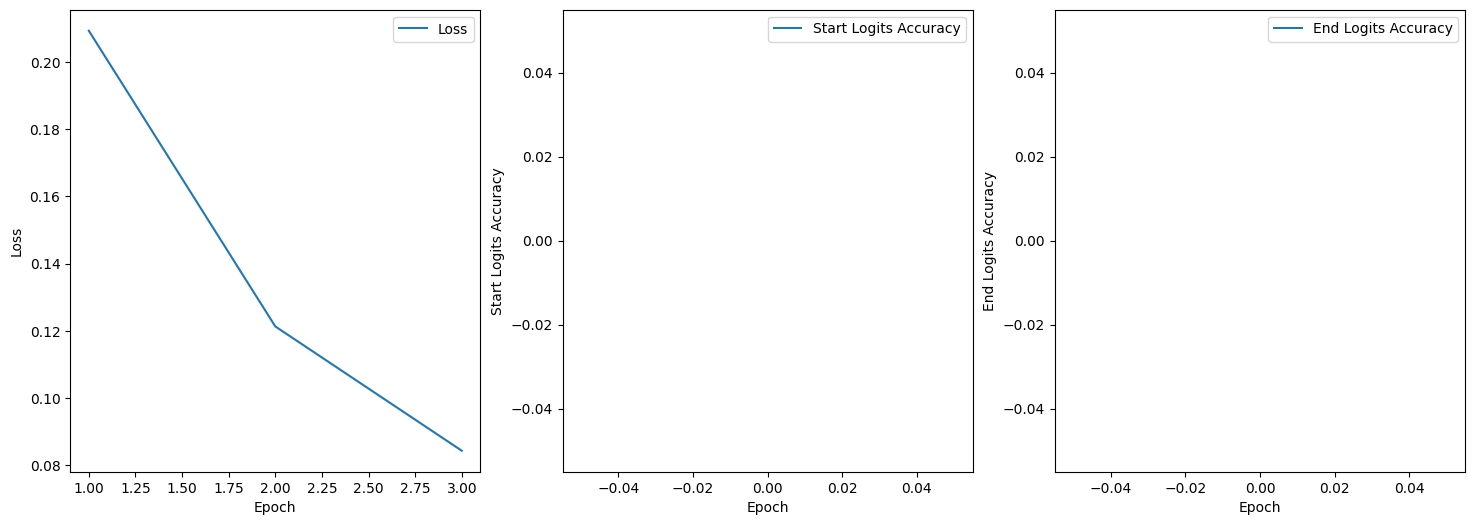

In [268]:
logger.plot()

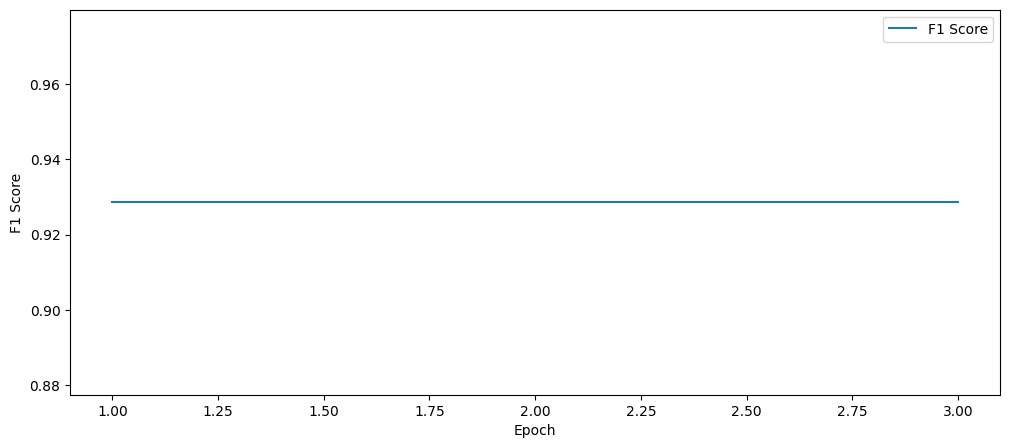

In [269]:
metrics_logger.plot()

In [335]:
# Buat dictionary kosong untuk menampung statistik pelatihan
training_stats = {
    'epoch': list(range(1, training_args.num_train_epochs + 1)),
    'loss': history.history['loss'],  # Gunakan loss dari history
    'val_loss': history.history['val_loss']  # Gunakan val_loss dari history
}

# Ambil metrik dari logger jika tersedia
if logger.start_logits_accuracy and logger.end_logits_accuracy:
    training_stats['start_logits_accuracy'] = logger.start_logits_accuracy
    training_stats['end_logits_accuracy'] = logger.end_logits_accuracy

# Ambil F1 score dari metrics logger jika tersedia
if metrics_logger.epoch_f1:
    training_stats['f1_score'] = metrics_logger.epoch_f1

# Buat DataFrame dari dictionary
df_stats = pd.DataFrame(training_stats)

# Setel indeks DataFrame menjadi kolom 'epoch'
df_stats = df_stats.set_index('epoch')

# Setel opsi untuk menampilkan presisi desimal
pd.set_option('display.precision', 2)

# Hapus baris dengan nilai None
df_stats = df_stats.dropna(axis=1, how='all')
# pd.set_option('display.precision', 2)

print(df_stats)


       loss  val_loss  f1_score
epoch                          
1      0.21      0.26      0.93
2      0.12      0.28      0.93
3      0.08      0.28      0.93


In [287]:
# Function to provide a recommendation when no answer is found in the dataset
def provide_recommendation():
    return ("Terima kasih atas pertanyaannya! Meskipun tidak ada jawaban langsung dari kami, berikut adalah "
            "beberapa rekomendasi umum untuk membantu keuangan anda:\n\n"
            "1. Mulailah dengan membuat anggaran dan mengelola pengeluaran Anda dengan cermat.\n"
            "2. Pertimbangkan untuk mencari peluang sampingan atau pekerjaan paruh waktu.\n"
            "3. Pelajari dan investasikan uang Anda dengan bijak. Mungkin Anda ingin mempertimbangkan untuk berinvestasi dalam saham, obligasi, atau properti.\n"
            "4. Kembangkan keterampilan yang bernilai tinggi dan pertimbangkan untuk memonetisasi hobi atau minat Anda.\n"
            "5. Jangan lupa untuk memiliki perencanaan keuangan jangka panjang, termasuk perencanaan pensiun dan perlindungan asuransi.\n\n"
            "Semoga ini membantu Anda memulai perjalanan keuangan Anda!")

In [309]:
def answer_question(question, context, use_pretrained=False):
    if context is None:
        return provide_recommendation()  # Mengembalikan rekomendasi jika konteks tidak ditemukan

    inputs = tokenizer(question, context, return_tensors="tf", max_length=384, truncation=True)
    if use_pretrained:
        outputs = pretrained_model(inputs)
    else:
        outputs = model(inputs)

    # Mendapatkan indeks token dengan probabilitas tertinggi untuk awal dan akhir jawaban
    answer_start = tf.argmax(outputs.start_logits, axis=1).numpy()[0]
    answer_end = tf.argmax(outputs.end_logits, axis=1).numpy()[0]
    
    # Mengambil token jawaban dari konteks
    answer_tokens = inputs["input_ids"][0][answer_start:answer_end+1]
    
    # Mengkonversi token ke dalam teks
    answer = tokenizer.decode(answer_tokens)
    
    return answer


In [310]:
# Function to find context based on the question using Jaccard similarity
def find_context_for_question(question, dataframe):
    max_matched_words = 0
    best_matched_context = None
    context_found = False

    # Iterate through the rows of the dataframe
    for _, row in dataframe.iterrows():
        if question.strip().lower() in row['question'].strip().lower():
            best_matched_context = row['context']
            context_found = True
            break  # Break the loop if a matching context is found

    # If no exact match is found, find the best matching context based on the number of common words
    if not context_found:
        for _, row in dataframe.iterrows():
            dataset_tokens = set(row['question'].strip().lower().split())
            matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
            if matched_words > max_matched_words:
                max_matched_words = matched_words
                best_matched_context = row['context']

    return best_matched_context, context_found

In [311]:
# Function to provide a recommendation when no answer is found in the dataset
def provide_recommendation_for_question(question):
    # Implement your recommendation logic here based on the question
    return provide_recommendation() 

In [372]:
# User input for the question
# user_question = input("Enter your financial question: ")
# user_question = "Apa itu EBITDA"
user_question = "Apa yang dimaksud dengan layanan konseling keuangan di FinBoost"
# user_question = "Apa itu pengelolaan keuangan yang baik"

In [373]:
# Find context for the user's question
# context = find_context_for_question(user_question, df)
context, context_found = find_context_for_question(user_question, df)

In [374]:
# Function to find context based on the question
# Mendekati dataset
# Tidak disarankan karena halusinasi

def provide_recommendation_for_question(question):
    max_matched_words = 0
    best_matched_context = None

    # Iterate through the rows of the dataset
    for _, row in df.iterrows():
        dataset_tokens = set(row['question'].strip().lower().split())
        matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
        if matched_words > max_matched_words:
            max_matched_words = matched_words
            best_matched_context = row['context']

    if best_matched_context:
        return best_matched_context
    else:
        return provide_recommendation()

In [375]:
if context_found:
    # Get the answer to the user question using the found context
    answer = answer_question(user_question, context)
    print(f"Q: {user_question}\nA: {answer}")
else:
    # If context is not found, provide a recommendation based on the user's question
    answer = provide_recommendation_for_question(user_question)
    print(f"Q: {user_question}\nA: {answer}")

Q: Apa yang dimaksud dengan layanan konseling keuangan di FinBoost
A: konseling keuangan adalah layanan yang tersedia di finboost untuk membantu individu memahami situasi keuangan mereka, mengidentifikasi masalah, dan mengembangkan solusi yang


In [265]:
# Save the model at the end
# model.save_pretrained("../models/fine_tuned_model")
# tokenizer.save_pretrained("../models/fine_tuned_model")